### Standard LSTM Model with feature engineered data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import lime.lime_tabular as lime
import shap
from IPython.display import display, HTML

/Users/amalshar/miniforge3/envs/mlenv64/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tf.compat.v1.enable_eager_execution()

In [3]:
DATA_PATH = '/Users/amalshar/Desktop/USD/Fall 2025/Data Analysis/Final Project/daily_2025_engineered_data.csv'
GROUP_COLS = ['State Code', 'County Code', 'Site Num']
BASE_FEATURES = ['CO', 'SO2', 'NO2', 'O3', 'PM25', 'BarometricPressure', 'Temperature', 'WindResultant']

# Engineered feature names you created earlier (adjust if you added more)
ENG_FEATURES = [
    'AQI_lag_1','AQI_lag_3','AQI_lag_7',
    'AQI_roll_3','AQI_roll_7',
    'CO_roll_3','CO_roll_7','NO2_roll_3','NO2_roll_7','PM25_roll_3','PM25_roll_7','O3_roll_3','O3_roll_7',
    'month','dayofweek','is_weekend','dayofyear',
    'PM25xTemp','NO2xWind'
]

TARGET = 'DailyAQI'
FEATURES = BASE_FEATURES + ENG_FEATURES

In [4]:
TIME_STEPS = 30                # longer temporal context
USE_LOG_TARGET = True          # robust to spikes
BATCH_SIZE = 128               # faster on CPU
EPOCHS = 200

In [5]:
df = pd.read_csv(DATA_PATH)
df['Date Local'] = pd.to_datetime(df['Date Local'], errors='coerce')

# Ensure proper ordering for group-wise ops
df = df.sort_values(GROUP_COLS + ['Date Local']).reset_index(drop=True)

# Keep only rows that have all required columns
needed_cols = GROUP_COLS + ['Date Local'] + FEATURES + [TARGET]
df = df.dropna(subset=needed_cols).copy()

print("Rows after cleaning:", len(df))
print("Date range:", df['Date Local'].min(), "->", df['Date Local'].max())

Rows after cleaning: 91740
Date range: 2025-01-01 00:00:00 -> 2025-07-01 00:00:00


In [6]:
# Global time split (70/10/20) to avoid leakage
dates_sorted = df['Date Local'].sort_values().values
cut1 = np.quantile(dates_sorted, 0.70)
cut2 = np.quantile(dates_sorted, 0.80)

train_df = df[df['Date Local'] <= cut1].copy()
val_df   = df[(df['Date Local'] > cut1) & (df['Date Local'] <= cut2)].copy()
test_df  = df[df['Date Local'] > cut2].copy()

print(f"Train/Val/Test sizes: {len(train_df)}, {len(val_df)}, {len(test_df)}")

Train/Val/Test sizes: 64291, 9124, 18325


In [7]:
X_train_raw = train_df[FEATURES].values
X_val_raw   = val_df[FEATURES].values
X_test_raw  = test_df[FEATURES].values

y_train_raw = train_df[[TARGET]].values
y_val_raw   = val_df[[TARGET]].values
y_test_raw  = test_df[[TARGET]].values

# Target transform (log1p optional)
if USE_LOG_TARGET:
    y_train_t = np.log1p(y_train_raw)
    y_val_t   = np.log1p(y_val_raw)
    y_test_t  = np.log1p(y_test_raw)
else:
    y_train_t, y_val_t, y_test_t = y_train_raw, y_val_raw, y_test_raw

In [8]:
# Feature scaler
scaler_X = MinMaxScaler().fit(X_train_raw)
X_train_s = scaler_X.transform(X_train_raw)
X_val_s   = scaler_X.transform(X_val_raw)
X_test_s  = scaler_X.transform(X_test_raw)

# Target scaler (robust)
scaler_y = RobustScaler().fit(y_train_t)
y_train_s = scaler_y.transform(y_train_t)
y_val_s   = scaler_y.transform(y_val_t)
y_test_s  = scaler_y.transform(y_test_t)

# Put back into DataFrames for grouped sequence building
train_df_s = train_df[GROUP_COLS + ['Date Local']].copy()
val_df_s   = val_df[GROUP_COLS + ['Date Local']].copy()
test_df_s  = test_df[GROUP_COLS + ['Date Local']].copy()

for i, col in enumerate(FEATURES):
    train_df_s[col] = X_train_s[:, i]
    val_df_s[col]   = X_val_s[:, i]
    test_df_s[col]  = X_test_s[:, i]

train_df_s['y_s'] = y_train_s
val_df_s['y_s']   = y_val_s
test_df_s['y_s']  = y_test_s

In [9]:
def build_sequences_by_group(frame, features, target_col, time_steps, group_cols):
    Xs, ys = [], []
    for _, g in frame.groupby(group_cols, sort=False):
        g = g.sort_values('Date Local')
        Xg = g[features].values
        yg = g[[target_col]].values
        if len(g) <= time_steps: 
            continue
        for i in range(len(g) - time_steps):
            Xs.append(Xg[i:i+time_steps])
            ys.append(yg[i+time_steps])
    return np.array(Xs), np.array(ys)

X_train, y_train = build_sequences_by_group(train_df_s, FEATURES, 'y_s', TIME_STEPS, GROUP_COLS)
X_val,   y_val   = build_sequences_by_group(val_df_s,   FEATURES, 'y_s', TIME_STEPS, GROUP_COLS)
X_test,  y_test  = build_sequences_by_group(test_df_s,  FEATURES, 'y_s', TIME_STEPS, GROUP_COLS)

print("Shapes -> Train:", X_train.shape, y_train.shape, "| Val:", X_val.shape, y_val.shape, "| Test:", X_test.shape, y_test.shape)

Shapes -> Train: (54436, 30, 27) (54436, 1) | Val: (2942, 30, 27) (2942, 1) | Test: (13714, 30, 27) (13714, 1)


In [10]:
model = Sequential([
    Input(shape=(TIME_STEPS, len(FEATURES))),
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(64),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.Huber(delta=1.0),
    metrics=['mae']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       159,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,313 (958.25 KB)

 Trainable params: 244,673 (955.75 KB)

 Non-trainable params: 640 (2.50 KB)

In [11]:
early_stop = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-5, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/200
426/426 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - loss: 0.2442 - mae: 0.5330 - val_loss: 0.1970 - val_mae: 0.4394 - learning_rate: 0.0010
Epoch 2/200
426/426 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - loss: 0.1507 - mae: 0.3909 - val_loss: 0.2911 - val_mae: 0.6547 - learning_rate: 0.0010
Epoch 3/200
426/426 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - loss: 0.1332 - mae: 0.3561 - val_loss: 0.1446 - val_mae: 0.4509 - learning_rate: 0.0010
Epoch 4/200
426/426 ━━━━━━━━━━━━━━━━━━━━ 35s 83ms/step - loss: 0.1232 - mae: 0.3360 - val_loss: 0.0866 - val_mae: 0.2869 - learning_rate: 0.0010
Epoch 5/200
426/426 ━━━━━━━━━━━━━━━━━━━━ 37s 87ms/step - loss: 0.1170 - mae: 0.3241 - val_loss: 0.0454 - val_mae: 0.1849 - learning_rate: 0.0010
Epoch 6/200
426/426 ━━━━━━━━━━━━━━━━━━━━ 37s 86ms/step - loss: 0.1120 - mae: 0.3137 - val_loss: 0.0546 - val_mae: 0.2356 - learning_rate: 0.0010
Epoch 7/200
426/426 ━━━━━━━━━━━━━━━━━━━━ 34s 80ms/step - loss: 0.1079 - mae: 0.3065 - val_loss: 0.0471 - val_mae: 0.2013 - learnin

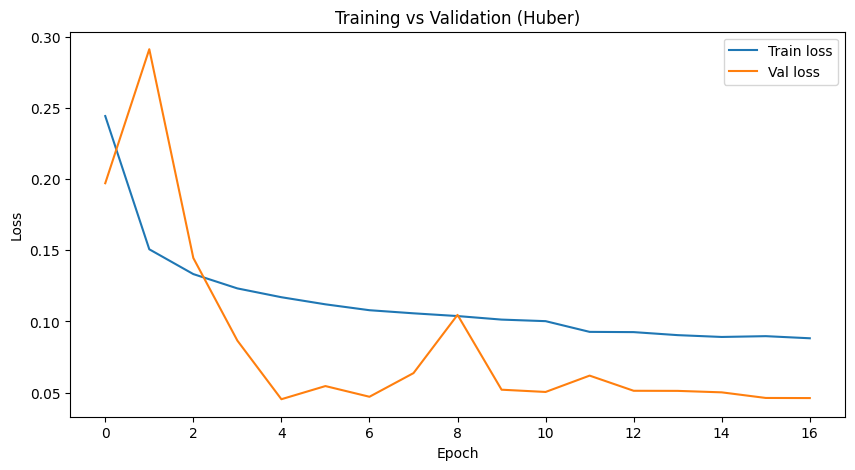

In [12]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Training vs Validation (Huber)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

In [13]:
def invert_target(y_scaled):
    inv = scaler_y.inverse_transform(y_scaled)
    if USE_LOG_TARGET:
        inv = np.expm1(inv)
    return inv

In [14]:
y_pred_s = model.predict(X_test)
y_pred   = invert_target(y_pred_s)
y_true   = invert_target(y_test)

429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step


In [15]:
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-6))) * 100
r2   = r2_score(y_true, y_pred)

In [16]:
print(f"MSE: {mse:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f} | MAPE: {mape:.2f}% | R²: {r2:.3f}")

MSE: 279.115 | RMSE: 16.707 | MAE: 9.890 | MAPE: 24.90% | R²: 0.695


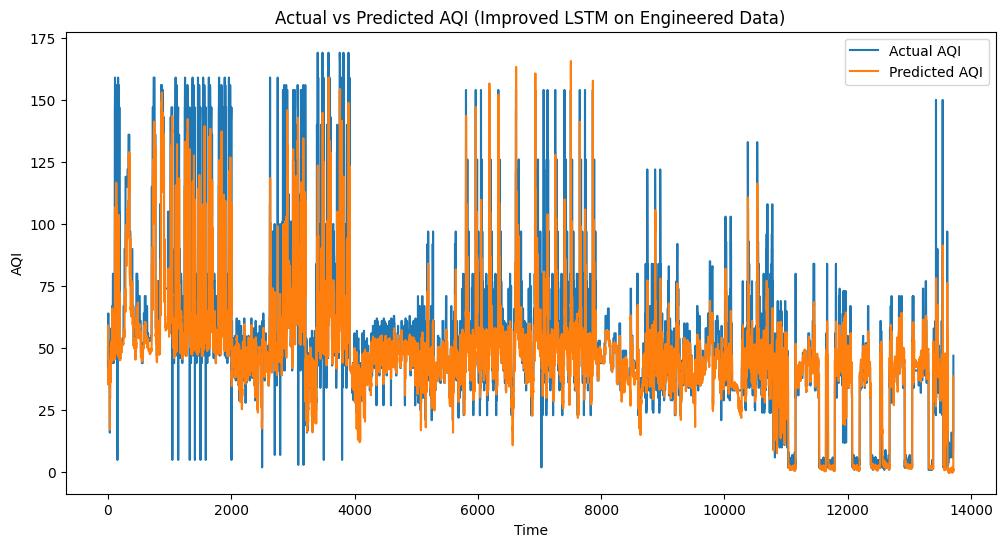

In [17]:
plt.figure(figsize=(12,6))
plt.plot(y_true, label='Actual AQI')
plt.plot(y_pred, label='Predicted AQI')
plt.title('Actual vs Predicted AQI (Improved LSTM on Engineered Data)')
plt.xlabel('Time'); plt.ylabel('AQI'); plt.legend(); plt.show()

In [18]:
def permutation_importance_lstm(model, X_test, y_true, feature_names, time_steps, n_repeats=3, metric=r2_score):
    base = invert_target(model.predict(X_test))
    base_score = metric(y_true, base)
    scores = {f: [] for f in feature_names}

    for j, f in enumerate(feature_names):
        for _ in range(n_repeats):
            Xp = X_test.copy()
            perm = np.random.permutation(Xp.shape[0])
            Xp[:, :, j] = Xp[perm, :, j]  # shuffle feature j across samples
            pred = invert_target(model.predict(Xp))
            scores[f].append(base_score - metric(y_true, pred))
    return {k: float(np.mean(v)) for k, v in scores.items()}

429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 5s 13

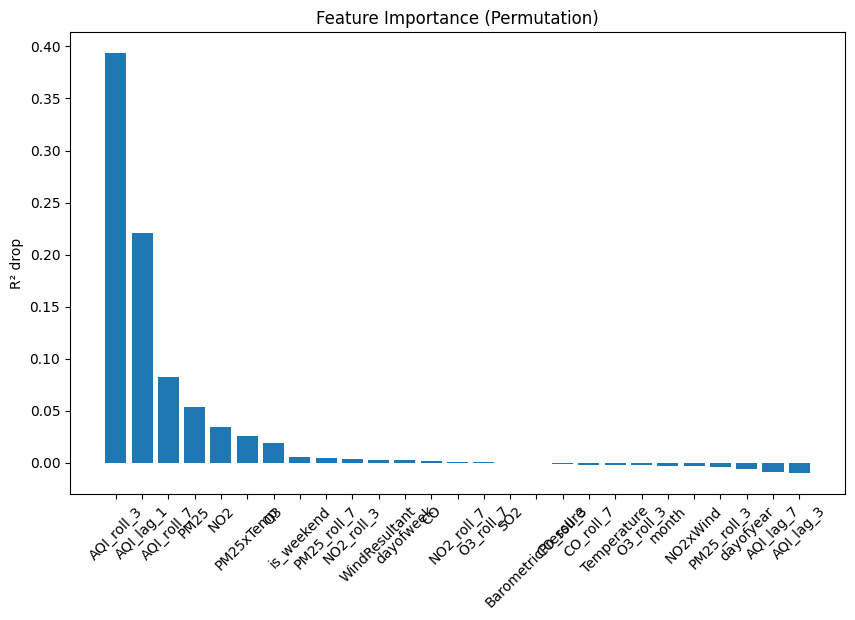

In [19]:
feat_importance = permutation_importance_lstm(model, X_test, y_true, FEATURES, TIME_STEPS)
imp_df = pd.DataFrame(sorted(feat_importance.items(), key=lambda x: x[1], reverse=True), columns=['Feature','Importance'])
print("\nPermutation Importance (R² drop):\n", imp_df)

plt.figure(figsize=(10,6))
plt.bar(imp_df['Feature'], imp_df['Importance'])
plt.xticks(rotation=45); plt.ylabel('R² drop'); plt.title('Feature Importance (Permutation)'); plt.show()

In [20]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)
feature_names_flat = [f"{f}_t-{t}" for t in range(TIME_STEPS) for f in FEATURES]

def predict_wrapper(flat_batch):
    reshaped = flat_batch.reshape(-1, TIME_STEPS, len(FEATURES))
    return model.predict(reshaped).flatten()

lime_explainer = lime.LimeTabularExplainer(
    training_data=X_train_flat,
    feature_names=feature_names_flat,
    mode='regression'
)

i = 0
exp = lime_explainer.explain_instance(
    data_row=X_test_flat[i],
    predict_fn=predict_wrapper,
    num_features=12
)

try:
    exp.show_in_notebook(show_table=True)
except Exception:
    display(HTML(exp.as_html()))

with open("exp7_lime_explanation.html", "w") as f:
    f.write(exp.as_html())

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step


 10%|█         | 1/10 [00:08<01:19,  8.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step


 20%|██        | 2/10 [00:18<01:12,  9.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step


 30%|███       | 3/10 [00:26<01:01,  8.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step


 40%|████      | 4/10 [00:34<00:51,  8.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step


 50%|█████     | 5/10 [00:42<00:41,  8.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step


 60%|██████    | 6/10 [00:50<00:33,  8.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step


 70%|███████   | 7/10 [00:59<00:24,  8.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step


 80%|████████  | 8/10 [01:07<00:16,  8.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step


 90%|█████████ | 9/10 [01:16<00:08,  8.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step


100%|██████████| 10/10 [01:25<00:00,  8.56s/it]


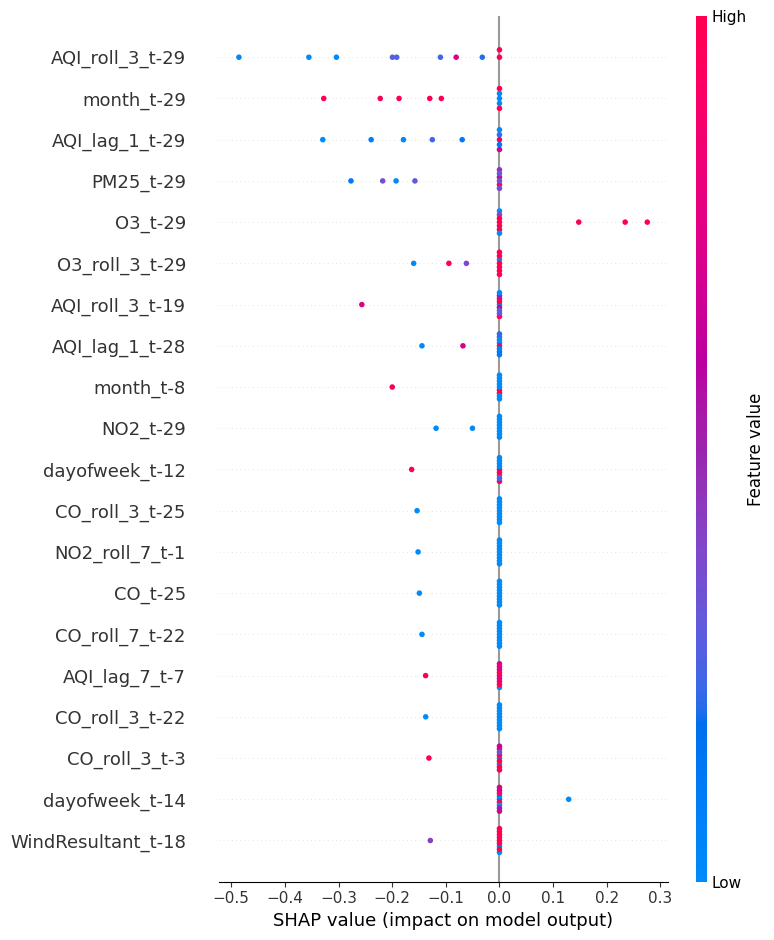

In [21]:
background = X_train_flat[:100]
test_samples = X_test_flat[:10]

shap_explainer = shap.KernelExplainer(predict_wrapper, background)
shap_values = shap_explainer.shap_values(test_samples, nsamples=200)

shap.summary_plot(shap_values, test_samples, feature_names=feature_names_flat)